# CFD-scale OSV

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import CoolProp.CoolProp as CP
import matplotlib.cm as cm
import matplotlib as mpl
from pylab import *


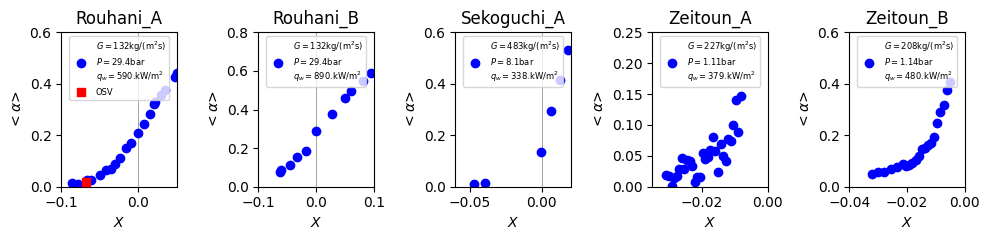

In [102]:
df_exemples_alpha_z = pd.read_csv("data/Exemple_alpha_of_x/conditions.csv", skiprows=[1])

fig = plt.figure(figsize = (10,2.5))
axs = fig.subplots(1, 5)

x_lim = [ [-.1, .05], [-.1, .1], [-.06, .02], [-.035, 0], [-.04, .0]]
y_lim = [ [0,.6], [0,.8], [0,.6], [0,.25], [0,.6]]

for e, row in df_exemples_alpha_z.iterrows() :
    df_loc = pd.read_csv(f"data/Exemple_alpha_of_x/{row['Run']}.csv")

    str_title = row["Run"]
    str_label = r"$G=$" + str(row["G"])[:3] + r"kg/(m$^2$s)"
    str_label+= "\n" + r"$P=$" + str(row["P"])[:4] + "bar"
    str_label+= "\n" + r"$q_w=$" + str(row["Phi"])[:4] + r"kW/m$^2$"

    axs[e].scatter(df_loc["X"], df_loc["alp"], color = "blue", label = str_label)
    axs[e].set_title(str_title)
    axs[e].set_xlim(x_lim[e])
    axs[e].set_ylim(y_lim[e])
    axs[e].set_xlabel(r"$X$")
    axs[e].set_ylabel(r"$<\alpha$>")
    axs[e].plot([0,0], [0,1], "-", color = "gray", zorder = -10, linewidth = 0.5)
    axs[e].legend(fontsize = 6, loc="upper center")
axs[0].scatter(-0.067447, 0.02, color = "red", marker = "s", zorder= 100, label = "OSV")
axs[0].legend(fontsize = 6, loc="upper center")

fig.tight_layout()
fig.savefig("figures/exemple_alpha_of_x.pdf")


In [103]:
df = pd.read_csv("data/OSV_database.csv", skiprows=[1])#, usecols = "A:H,L,M,P,U,V")
print(df.keys())

tab_rhotio = []
tab_G = []
tab_U_in = []
tab_DT_OSV = []
tab_X_OSV = []
tab_X_SZ = []
tab_X_SZh = []
tab_rhol = []
tab_Re = []
tab_Pr = []
tab_Pe = []  # Hydraulic diameter Peclet
tab_Peh = [] # Heated hydraulic diameter Peclet
tab_Nu = []
tab_Nuh = []
tab_mul = []
tab_lambdal = []
tab_mulsat = []
tab_lambdalsat = []
tab_Cpl = []
tab_St = []
tab_utau = []
tab_yp_crit = []
tab_Dh_heated = []

for e, row in df.iterrows() :
    if   (row["Geometrie"] == "Annular") : tab_Dh_heated += [(row["Big_length"]**2 - row["Small_length"]**2)/(row["Small_length"])]
    elif (row["Geometrie"] == "Tube")    : tab_Dh_heated += [row["Big_length"]]
    elif (row["Geometrie"] == "Channel") and (row["Source"] == "Martin")  : tab_Dh_heated += [ 2 * row["Small_length"]] # Normalement 2, 2 cotes chauffants
    elif (row["Geometrie"] == "Channel") and (row["Source"] == "Staub_Ch"): tab_Dh_heated += [ 2 * row["Small_length"]] # Normalement 2 !? 1 seul cote chauffant
    elif (row["Geometrie"] == "Channel") and (row["Source"] == "Egen")    : tab_Dh_heated += [ 2 * row["Small_length"]] # 1 seul cote chauffant sans savoir
    else : print("Missing Dhh!")
df["Dhh"] = tab_Dh_heated

for e, row in df.iterrows() :
    Ts  = CP.PropsSI("T", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])
    tab_rhotio += [CP.PropsSI("DMASS", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])/CP.PropsSI("DMASS", "P", row["Pressure"]*1.e5, "Q", 1, row["Fluide"])]

    Hsl = CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])
    Hsv = CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "Q", 1, row["Fluide"])

    if row["DT_OSV"]>0 : 
        tab_X_OSV += [(CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "T", Ts-row["DT_OSV"], row["Fluide"])-Hsl) / (Hsv-Hsl)]
        tab_DT_OSV += [row["DT_OSV"]]
    else : 
        row["DT_OSV"] = Ts - CP.PropsSI( "T", "P", row["Pressure"]*1.e5, "HMASS", row["X_OSV"] * (Hsv-Hsl) + Hsl, row["Fluide"])
        tab_X_OSV += [row["X_OSV"]]
        tab_DT_OSV += [Ts - CP.PropsSI( "T", "P", row["Pressure"]*1.e5, "HMASS", row["X_OSV"] * (Hsv-Hsl) + Hsl, row["Fluide"])]

    rhol = CP.PropsSI("DMASS", "P", row["Pressure"]*1.e5, "T", Ts-row["DT_OSV"], row["Fluide"])
    tab_rhol += [rhol]
    if row["G"]>0 : 
        tab_U_in += [row["G"]/rhol]
        row["u_in"] = row["G"]/rhol
        tab_G += [row["G"]]
    else : 
        tab_U_in += [row["u_in"]]
        tab_G += [row["u_in"] * rhol]
        row["G"] = row["u_in"] * rhol

    # Here we look at adimensional numbers at bulk viscosity and volume mass => debatable
    if row["Fluide"] == "R114" :
        lambdal = row["lambdal"]
        mul     = row["mul"]
        lambdalsat = row["lambdalsat"]
        mulsat     = row["mulsat"]
    else :
        lambdal = CP.PropsSI("CONDUCTIVITY", "P", row["Pressure"]*1.e5, "T", Ts-row["DT_OSV"], row["Fluide"])
        mul     = CP.PropsSI("VISCOSITY"   , "P", row["Pressure"]*1.e5, "T", Ts-row["DT_OSV"], row["Fluide"])
        lambdalsat = CP.PropsSI("CONDUCTIVITY", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])
        mulsat     = CP.PropsSI("VISCOSITY"   , "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])

    nul     = mul/rhol
    tab_mul+= [nul*rhol]
    Cpl     = CP.PropsSI("CPMASS"      , "P", row["Pressure"]*1.e5, "T", Ts-row["DT_OSV"], row["Fluide"]) 
    tab_lambdal+= [lambdal]
    tab_mulsat+= [nul*rhol]
    tab_lambdalsat+= [lambdal]
    tab_Cpl+= [Cpl]
    tab_Re += [row["G"]*row["Dh"]*1.e-3/mul]
    tab_Pr += [rhol * nul * Cpl/ lambdal]
    tab_Pe += [row["G"]*row["Dh"]*1.e-3*Cpl/lambdal]
    tab_Peh+= [row["G"]*row["Dhh"]*1.e-3*Cpl/lambdal]
    tab_Nuh+= [row["q"]*1.e3*row["Dhh"]*1.e-3/(row["DT_OSV"] *lambdal )]
    tab_Nu += [row["q"]*1.e3*row["Dh"]*1.e-3/(row["DT_OSV"] *lambdal )]
    tab_St += [row["q"]*1.e3/(row["G"] * row["DT_OSV"] * CP.PropsSI("CPMASS", "P", row["Pressure"]*1.e5, "T", Ts-row["DT_OSV"], row["Fluide"]))]

    # friction velocity depends on geometry
    if row["u_tau"] >0 :
        utau = row["u_tau"]
    elif row["Geometrie"] == "Tube" :
        if tab_Re[-1] < 30000 : utau = (0.316 * tab_Re[-1]**-0.25 * 1./8)**.5*tab_U_in[-1] #Blasius
        else : utau = (0.184 * tab_Re[-1]**-0.2 * 1./8)**.5*tab_U_in[-1] #MacAdams
    elif row["Geometrie"] == "Channel" : # Dichotomy + log-law hypothesis
        ut0 = 1.e-4
        ut1 = 1
        while ut1-ut0>1.e-4 :
            utloc = (ut1+ut0)/2
            ubulk_calc = utloc*(5.2+1/0.41*(np.log(utloc*row["Small_length"]*1.e-3/(2*nul))-1))
            if utloc*(5.2+1/0.41*(np.log(utloc*row["Small_length"]*1.e-3/(2*nul))-1)) > row["u_in"] : ut1 = utloc
            else : ut0 = utloc
        utau = (ut1+ut0)/2
    elif row["Geometrie"] == "Annular" : # not calculated yet
        if tab_Re[-1] < 30000 : utau = (0.316 * tab_Re[-1]**-0.25 * 1./8)**.5*tab_U_in[-1] #Blasius
        else : utau = (0.184 * tab_Re[-1]**-0.2 * 1./8)**.5*tab_U_in[-1] #MacAdams

    tab_utau += [utau]

    if tab_Pe[-1] > 70000 : tab_X_SZ += [-154 * 1.e3*row["q"] / (row["G"] * (Hsv - Hsl))]
    else : tab_X_SZ += [-0.0022 * 1.e3*row["q"] * 1.e-3*row["Dh"] * Cpl/((Hsv - Hsl) *lambdal ) ]

    if tab_Peh[-1] > 70000 : tab_X_SZh += [-154 * 1.e3*row["q"] / (row["G"] * (Hsv - Hsl))]
    else : tab_X_SZh += [-0.0022 * 1.e3*row["q"] * 1.e-3*row["Dhh"] * Cpl/((Hsv - Hsl) *lambdal ) ]

df["rhotio"] = tab_rhotio
df["rhol"] = tab_rhol
df["mul"] = tab_mul
df["lambdal"] = tab_lambdal
df["mulsat"] = tab_mulsat
df["lambdalsat"] = tab_lambdalsat
df["Cpl"] = tab_Cpl
df["Re"]  = tab_Re
df["Pr"]  = tab_Pr
df["Pe"]  = tab_Pe
df["Nu"]  = tab_Nu
df["Peh"] = tab_Peh
df["Nuh"] = tab_Nuh
df["St"]  = tab_St
df["G"]   = tab_G
df["u_in"] = tab_U_in
df["DT_OSV"] = tab_DT_OSV
df["X_OSV"] = tab_X_OSV
df["X_SZ"] = tab_X_SZ
df["X_SZh"] = tab_X_SZh
df["utau"] = tab_utau

print(df.keys())


Index(['Source', 'Fluide', 'Dh', 'Small_length', 'Big_length', 'Geometrie',
       'Pressure', 'G', 'u_in', 'q', 'X_OSV', 'DT_OSV', 'u_tau'],
      dtype='object')
Index(['Source', 'Fluide', 'Dh', 'Small_length', 'Big_length', 'Geometrie',
       'Pressure', 'G', 'u_in', 'q', 'X_OSV', 'DT_OSV', 'u_tau', 'Dhh',
       'rhotio', 'rhol', 'mul', 'lambdal', 'mulsat', 'lambdalsat', 'Cpl', 'Re',
       'Pr', 'Pe', 'Nu', 'Peh', 'Nuh', 'St', 'X_SZ', 'X_SZh', 'utau'],
      dtype='object')


In [104]:
# df indexes we can call
# 'Source' source paper
# 'ok' if point is considered accurate enough
# 'Fluide'
# 'Dh' Hydraulic diameter
# 'Dhh' Heated hydraulic diameter
# 'Geometrie'
# 'Pressure'
# 'G'mass flow rate
# 'q' power (W/m2)
# 'X_OSV' measured osv quality
# 'DT_OSV' measured osv subcooling
# 'rhotio' density ratio
# 'Re', 'Pe', 'Nu', 'St', 'X_SZ' adim numbers and OSV quality calculated with hydraulic diameter
# 'Peh', 'Nuh', 'X_SZh' adim numbers calculated with hydraulic heated diameter
# 'Pr'
# 'utau' single-phase friction velocity


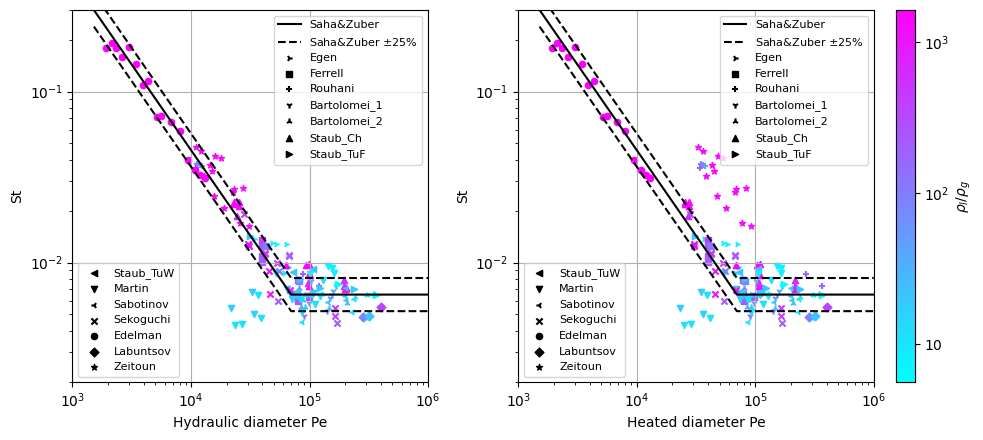

In [105]:
dict_marker  = { "Egen" : "4",
                 "Ferrell" : "s",
                 "Rouhani" : "+",
                 "Bartolomei_1" : "1",
                 "Bartolomei_2" : "2",
                 "Staub_Ch" : "^",
                 "Staub_TuF" : ">",
                 "Staub_TuW" : "<",
                 "Martin" : "v",
                 "Sabotinov" : "3",
                 "Sekoguchi" : "x",
                 "Edelman" : "o",
                 "Labuntsov" : "D",
                 "Zeitoun" : "*"
                 }

norm_cm = mpl.colors.Normalize(np.log10(min(df["rhotio"])), np.log10(max(df["rhotio"])))
cmap = cm.cool
m = cm.ScalarMappable(norm=norm_cm, cmap=cmap)

fig = plt.figure(figsize = (10,4.5))

(ax1, ax2) = fig.subplots(1, 2, width_ratios=[4, 5])

legended = ["Saha&Zuber", r"Saha&Zuber $\pm25\%$"]

absc_SZ = np.array([455/.3  ,70e3, 1.e6])
ord_SZ  = np.array([0.3, 0.0065, 0.0065])

tab_p = [ax1.plot(absc_SZ,  ord_SZ, 'k-', label = "Saha&Zuber")[0]]
tab_p+= [ax1.plot(absc_SZ,  ord_SZ*1.25, 'k--', label = r"Saha&Zuber $\pm25\%$")[0]]
ax1.plot(absc_SZ,  ord_SZ/1.25, 'k--')

for e, row in df.iterrows() :
    ax1.scatter( row["Pe"], row["St"], s = 20, marker = dict_marker[row["Source"]], color = m.to_rgba(np.log10(row["rhotio"])))
    
for e, row in df.iterrows() :
    if not (row["Source"] in legended) :
        tab_p += [ax1.scatter( 1.e8, 1.e8, s = 20, marker = dict_marker[row["Source"]], color = "k", label = row["Source"])]
        legended += [row["Source"]]


ax1b = ax1.twinx()
ax1b.axis('off')
ax1.legend(tab_p[:9], legended[:9],fontsize = 8, loc = "upper right")
ax1b.legend(tab_p[9:], legended[9:],fontsize = 8, loc = "lower left")


legended = ["Saha&Zuber", r"Saha&Zuber $\pm25\%$"]

absc_SZ = np.array([455/.3  ,70e3, 1.e6])
ord_SZ  = np.array([0.3, 0.0065, 0.0065])

tab_p = [ax2.plot(absc_SZ,  ord_SZ, 'k-', label = "Saha&Zuber")[0]]
tab_p+= [ax2.plot(absc_SZ,  ord_SZ*1.25, 'k--', label = r"Saha&Zuber $\pm25\%$")[0]]
ax2.plot(absc_SZ,  ord_SZ/1.25, 'k--')


for e, row in df.iterrows() :
    ax2.scatter( row["Peh"], row["St"], s = 20, marker = dict_marker[row["Source"]], color = m.to_rgba(np.log10(row["rhotio"])))
    
for e, row in df.iterrows() :
    if not (row["Source"] in legended) :
        tab_p += [ax2.scatter( 1.e8, 1.e8, s = 20, marker = dict_marker[row["Source"]], color = "k", label = row["Source"])]
        legended += [row["Source"]]

ax2b = ax2.twinx()
ax2b.axis('off')
ax2.legend(tab_p[:9], legended[:9],fontsize = 8, loc = "upper right")
ax2b.legend(tab_p[9:], legended[9:],fontsize = 8, loc = "lower left")


cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_cm, cmap=cmap),
             orientation='vertical', label=r'$\rho_l/\rho_g$', ticks=[1,2,3], ax=ax2)
cbar.ax.set_yticklabels([r"$10$", r"$10^2$", r"$10^3$"])  # vertically oriented colorbar
cbarb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_cm, cmap=cmap),
             orientation='vertical', label=' ', ticks=[], ax=ax2b)

for ax in (ax1,ax2):
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlim(1.e3, 1.e6)
    ax.set_ylim(2.e-3, .3)
    ax.set_ylabel("St")
    ax.grid(visible=True)

ax1.set_xlabel("Hydraulic diameter Pe")
ax2.set_xlabel("Heated diameter Pe")

plt.tight_layout()

plt.savefig("figures/SZ_correlation.pdf")


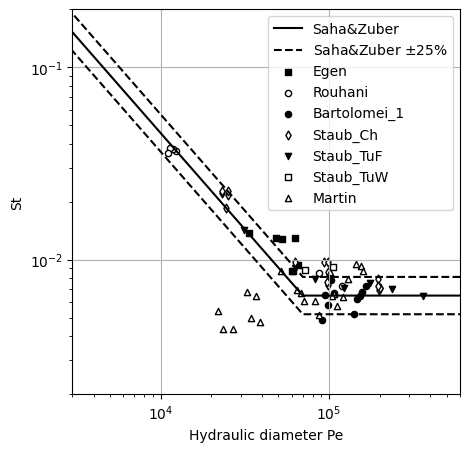

In [106]:
plt.figure(figsize = (5,5))

df_SZ = df[ (df["Source"]=="Rouhani") | (df["Source"]=="Egen") | (df["Source"]=="Martin") | (df["Source"]=="Staub_TuF") | (df["Source"]=="Staub_TuW") | (df["Source"]=="Staub_Ch") | (df["Source"]=="Bartolomei_1") ]

legended = []

plt.plot(absc_SZ,  ord_SZ, 'k-', label = "Saha&Zuber")
plt.plot(absc_SZ,  ord_SZ*1.25, 'k--', label = r"Saha&Zuber $\pm25\%$")
plt.plot(absc_SZ,  ord_SZ/1.25, 'k--')

for e, row in df_SZ.iterrows() :
    if row["Source"] == "Rouhani"    : mkr, mkrc, mkrec = "o", "white", "black" 
    if row["Source"] == "Egen"       : mkr, mkrc, mkrec = "s", "black", "black" 
    if row["Source"] == "Martin"     : mkr, mkrc, mkrec = "^", "white", "black" 
    if row["Source"] == "Staub_TuF"  : mkr, mkrc, mkrec = "v", "black", "black" 
    if row["Source"] == "Staub_TuW"  : mkr, mkrc, mkrec = "s", "white", "black" 
    if row["Source"] == "Staub_Ch"   : mkr, mkrc, mkrec = "d", "white", "black" 
    if row["Source"] == "Bartolomei_1" : mkr, mkrc, mkrec = "o", "black", "black" 

    if row["Source"] in legended : plt.scatter( row["Pe"], row["St"], s = 20, marker = mkr, color = mkrc, edgecolors = mkrec)
    else :  
        plt.scatter( row["Pe"], row["St"], s = 20, marker = mkr, color = mkrc, edgecolors = mkrec, label = row["Source"])
        legended += [row["Source"]]

absc_SZ = np.array([455/.3  ,70e3, 1.e6])
ord_SZ  = np.array([0.3, 0.0065, 0.0065])

plt.legend()
plt.yscale("log")
plt.xscale("log")

plt.xlim(3.e3, 6.e5)
plt.ylim(2.e-3, 2.e-1)

plt.xlabel("Hydraulic diameter Pe")
plt.ylabel("St")
plt.grid(visible=True)

plt.savefig("figures/SZ_data.pdf")

/tmp/ipykernel_1260011/1905113924.py:27: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  tab_p += [plt.scatter( row["Pe"], row["St"], s = 20, marker = mkr, color = mkrc, edgecolors = mkrec, label = row["Source"])]
/tmp/ipykernel_1260011/1905113924.py:25: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  if row["Source"] in legended : plt.scatter( row["Pe"], row["St"], s = 20, marker = mkr, color = mkrc, edgecolors = mkrec)


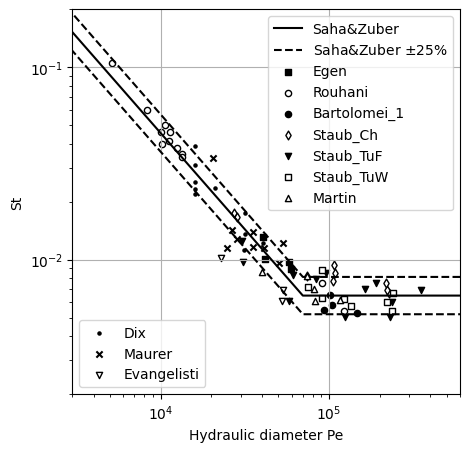

In [107]:
fig = plt.figure(figsize = (5,5))
ax2 = fig.subplots()

df_SZ_paper = pd.read_csv("data/SZ_data.csv")

legended = ["Saha&Zuber", r"Saha&Zuber $\pm25\%$"]
tab_p = []

tab_p += [plt.plot(absc_SZ,  ord_SZ, 'k-', label = "Saha&Zuber")[0]]
tab_p += [plt.plot(absc_SZ,  ord_SZ*1.25, 'k--', label = r"Saha&Zuber $\pm25\%$")[0]]
plt.plot(absc_SZ,  ord_SZ/1.25, 'k--')

for e, row in df_SZ_paper.iterrows() :
    if row["Source"] == "Rouhani"    : mkr, mkrc, mkrec = "o", "white", "black" 
    if row["Source"] == "Egen"       : mkr, mkrc, mkrec = "s", "black", "black" 
    if row["Source"] == "Martin"     : mkr, mkrc, mkrec = "^", "white", "black" 
    if row["Source"] == "Staub_TuF"  : mkr, mkrc, mkrec = "v", "black", "black" 
    if row["Source"] == "Staub_TuW"  : mkr, mkrc, mkrec = "s", "white", "black" 
    if row["Source"] == "Staub_Ch"   : mkr, mkrc, mkrec = "d", "white", "black" 
    if row["Source"] == "Bartolomei_1":mkr, mkrc, mkrec = "o", "black", "black" 
    if row["Source"] == "Dix"        : mkr, mkrc, mkrec = ".", "black", "black" 
    if row["Source"] == "Maurer"     : mkr, mkrc, mkrec = "x", "black", "black" 
    if row["Source"] == "Evangelisti": mkr, mkrc, mkrec = "v", "white", "black" 

    if row["Source"] in legended : plt.scatter( row["Pe"], row["St"], s = 20, marker = mkr, color = mkrc, edgecolors = mkrec)
    else :  
        tab_p += [plt.scatter( row["Pe"], row["St"], s = 20, marker = mkr, color = mkrc, edgecolors = mkrec, label = row["Source"])]
        legended += [row["Source"]]

plt.yscale("log")
plt.xscale("log")

plt.xlim(3.e3, 6.e5)
plt.ylim(2.e-3, 2.e-1)

plt.xlabel("Hydraulic diameter Pe")
plt.ylabel("St")
plt.grid(visible=True)

ax2b = ax2.twinx()
ax2.legend(tab_p[:9], legended[:9], loc = "upper right")
ax2b.axis("off")
ax2b.legend(tab_p[9:], legended[9:], loc = "lower left")
#ax2b.legend(tab_p[7:], legended[7:],fontsize = 8, loc = "lower left")

plt.savefig("figures/SZ_paper_data.pdf")

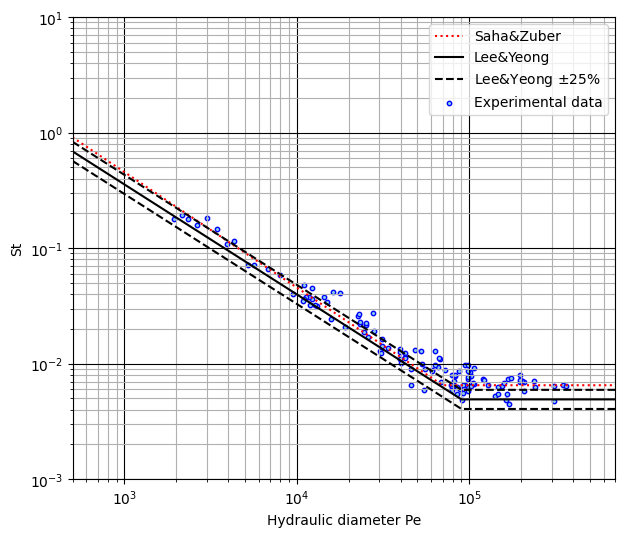

In [108]:
plt.figure(figsize = (7,6))

df_Lee = df[ (df["Source"]=="Edelman") | (df["Source"]=="Ferrell") | (df["Source"]=="Rouhani") | (df["Source"]=="Egen")  | (df["Source"]=="Bartolomei_1") | (df["Source"]=="Bartolomei_2") | (df["Source"]=="Sekoguchi") | (df["Source"]=="Zeitoun") | (df["Source"]=="Staub_Ch") | (df["Source"]=="Staub_TuF") | (df["Source"]=="Staub_TuW")]

legended = []

for e, row in df_Lee.iterrows() :
    plt.scatter( row["Pe"], row["St"], s = 10, marker = "o", edgecolors = "blue", color = "skyblue")

absc_SZ = np.array([455/3  ,70e3, 1.e6])
ord_SZ  = np.array([3, 0.0065, 0.0065])
plt.plot(absc_SZ,  ord_SZ, 'r:', label = "Saha&Zuber")
absc_Lee = np.array([5e2,90e3, 1.e6])
ord_Lee  = np.array([0.688, 0.0049, 0.0049])
plt.plot(absc_Lee, ord_Lee, 'k-', label = "Lee&Yeong")
plt.plot(absc_Lee, ord_Lee*1.21, 'k--', label = r"Lee&Yeong $\pm25\%$")
plt.plot(absc_Lee, ord_Lee/1.21, 'k--')
plt.scatter( 1, 1, s = 10, marker = "o", edgecolors = "blue", color = "skyblue", label = "Experimental data")

plt.legend()
plt.yscale("log")
plt.xscale("log")

plt.xlim(5.e2, 7.e5)
plt.ylim(1.e-3, 10.)

plt.xlabel("Hydraulic diameter Pe")
plt.ylabel("St")
plt.grid(visible=True, which="both")
plt.grid(visible=True, color ="0")

plt.savefig("figures/Lee_data.pdf")

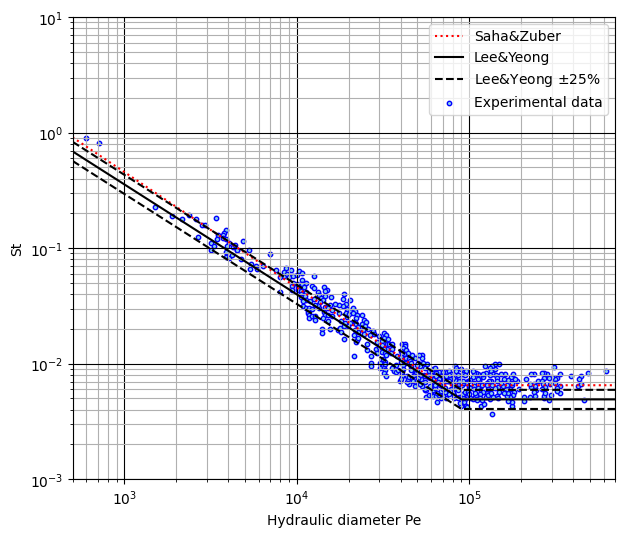

In [109]:
plt.figure(figsize = (7,6))

df_Lee_paper = pd.read_csv("data/Lee_data.csv")

legended = []

for e, row in df_Lee_paper.iterrows() :
    plt.scatter( row["Pe"], row["St"], s = 10, marker = "o", edgecolors = "blue", color = "skyblue")

absc_SZ = np.array([455/3  ,70e3, 1.e6])
ord_SZ  = np.array([3, 0.0065, 0.0065])
plt.plot(absc_SZ,  ord_SZ, 'r:', label = "Saha&Zuber")
absc_Lee = np.array([5e2,90e3, 1.e6])
ord_Lee  = np.array([0.688, 0.0049, 0.0049])
plt.plot(absc_Lee, ord_Lee, 'k-', label = "Lee&Yeong")
plt.plot(absc_Lee, ord_Lee*1.21, 'k--', label = r"Lee&Yeong $\pm25\%$")
plt.plot(absc_Lee, ord_Lee/1.21, 'k--')
plt.scatter( 1, 1, s = 10, marker = "o", edgecolors = "blue", color = "skyblue", label = "Experimental data")

plt.legend()
plt.yscale("log")
plt.xscale("log")

plt.xlim(5.e2, 7.e5)
plt.ylim(1.e-3, 10.)

plt.xlabel("Hydraulic diameter Pe")
plt.ylabel("St")
plt.grid(visible=True, which="both")
plt.grid(visible=True, color ="0")

plt.savefig("figures/Lee_data_paper.pdf")

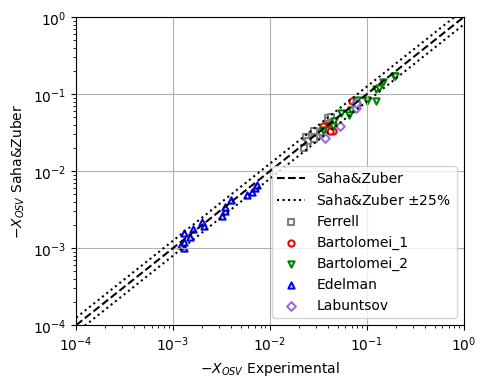

In [110]:
plt.figure(figsize = (5,4))

df_Cai = df[ (df["Source"]=="Ferrell") | (df["Source"]=="Bartolomei_1") | (df["Source"]=="Bartolomei_2") | (df["Source"]=="Labuntsov") | (df["Source"]=="Edelman")]

plt.plot([1.e-4, 1.], [1.e-4, 1.], "k--", label = r"Saha&Zuber")
plt.plot([1.e-4, 1.], [1.e-4*1.25, 1.*1.25], "k:", label = r"Saha&Zuber $\pm25\%$")
plt.plot([1.e-4, 1.], [1.e-4/1.25, 1./1.25], "k:")

legended = []

for e, row in df_Cai.iterrows() :
    if row["Source"] == "Ferrell"      : mkr, mkrc, mkrec = "s", "white", "grey" 
    if row["Source"] == "Bartolomei_1"   : mkr, mkrc, mkrec = "o", "white", "red" 
    if row["Source"] == "Bartolomei_2"   : mkr, mkrc, mkrec = "v", "white", "green" 
    if row["Source"] == "Edelman"      : mkr, mkrc, mkrec = "^", "white", "blue" 
    if row["Source"] == "Labuntsov"    : mkr, mkrc, mkrec = "D", "white", "mediumpurple" 

    if row["Source"] in legended : plt.scatter(-row["X_OSV"],-row["X_SZ"],  s = 20, marker = mkr, color = mkrc, edgecolors = mkrec, linewidths=1.5)
    else :  
        plt.scatter(-row["X_OSV"],-row["X_SZ"],  s = 20, marker = mkr, color = mkrc, edgecolors = mkrec, linewidths=1.5, label = row["Source"])
        legended += [row["Source"]]

plt.yscale("log")
plt.xscale("log")
plt.ylim(1.e-4, 1)
plt.xlim(1.e-4, 1)
plt.xlabel(r"$-X_{OSV}$ Experimental")
plt.ylabel(r"$-X_{OSV}$ Saha&Zuber")
plt.grid(visible=True)
plt.legend(loc="lower right")
plt.savefig("figures/Cai_Mudawar_data.pdf")

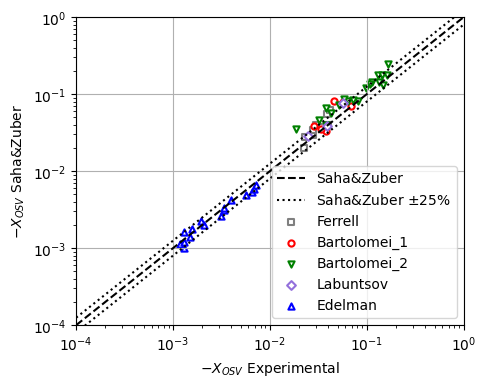

In [111]:
plt.figure(figsize = (5,4))

df_Cai_paper = pd.read_csv("data/Cai_data.csv")

plt.plot([1.e-4, 1.], [1.e-4, 1.], "k--", label = r"Saha&Zuber")
plt.plot([1.e-4, 1.], [1.e-4*1.25, 1.*1.25], "k:", label = r"Saha&Zuber $\pm25\%$")
plt.plot([1.e-4, 1.], [1.e-4/1.25, 1./1.25], "k:")

legended = []

for e, row in df_Cai_paper.iterrows() :
    if row["Source"] == "Ferrell"      : mkr, mkrc, mkrec = "s", "white", "grey" 
    if row["Source"] == "Bartolomei_1"   : mkr, mkrc, mkrec = "o", "white", "red" 
    if row["Source"] == "Bartolomei_2"   : mkr, mkrc, mkrec = "v", "white", "green" 
    if row["Source"] == "Edelman"      : mkr, mkrc, mkrec = "^", "white", "blue" 
    if row["Source"] == "Labuntsov"    : mkr, mkrc, mkrec = "D", "white", "mediumpurple" 

    if row["Source"] in legended : plt.scatter(row["Xexp"],row["Xpred"],  s = 20, marker = mkr, color = mkrc, edgecolors = mkrec, linewidths=1.5)
    else :  
        plt.scatter(row["Xexp"],row["Xpred"],  s = 20, marker = mkr, color = mkrc, edgecolors = mkrec, linewidths=1.5, label = row["Source"])
        legended += [row["Source"]]

plt.yscale("log")
plt.xscale("log")
plt.ylim(1.e-4, 1)
plt.xlim(1.e-4, 1)
plt.xlabel(r"$-X_{OSV}$ Experimental")
plt.ylabel(r"$-X_{OSV}$ Saha&Zuber")
plt.grid(visible=True)
plt.legend(loc="lower right")
plt.savefig("figures/Cai_Mudawar_paper_data.pdf")



In [112]:
dict_marker  = { "Egen" : "4",
                 "Ferrell" : "s",
                 "Rouhani" : "+",
                 "Bartolomei_1" : "1",
                 "Bartolomei_2" : "2",
                 "Staub_Ch" : "^",
                 "Staub_TuF" : ">",
                 "Staub_TuW" : "<",
                 "Martin" : "v",
                 "Sabotinov" : "3",
                 "Sekoguchi" : "x",
                 "Edelman" : "o",
                 "Labuntsov" : "D",
                 "Zeitoun" : "*"
                 }


In [113]:
def Tl_de_beta(source, geometrie, beta, Ts, pL, gL, q, rhol, Cpl, nul, utau) :
    if   geometrie == "Tube" : return Tl_de_beta_tube(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau)
    elif geometrie == "Annular" : return Tl_de_beta_anneau_interne(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau)
    elif source == "Martin" : return Tl_de_beta_canal_bichauffe(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau)
    elif source == "Egen"   : return Tl_de_beta_canal_bichauffe(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau)
    elif source == "Staub_Ch" : return Tl_de_beta_canal_monochauffe(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau)
    else : print("PROBLEM !!!")

def Tl_de_beta_canal_bichauffe(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau) :
    return Tl_de_beta_canal_bichauffe_integration_u(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau)

def Tl_de_beta_canal_bichauffe_integration_u(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau) :
    T_star = q/(rhol*Cpl*utau)
    y_integration = np.linspace(1.e-8,pL/2, 1000)
    yp = y_integration*utau/nul
    u_Reichardt   = np.log(1.+.4*yp)/.41+7.8*(1-np.exp(-yp/11)-yp/11*np.exp(-yp/3))
    u_integration = u_Reichardt
    Theta_p_integration = beta + 2.12*np.log(y_integration*utau/nul)
    Theta_p_integration = np.maximum(np.zeros(1000), Theta_p_integration)
    T_integration = Theta_p_integration*T_star
    rep = np.trapz( T_integration*u_integration,y_integration) /np.trapz( u_integration,y_integration)
    return Ts-rep

def Tl_de_beta_canal_monochauffe(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau) :
    return Tl_de_beta_canal_monochauffe_integration_u(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau)

def Tl_de_beta_canal_monochauffe_integration_u(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau) :
    T_star = q/(rhol*Cpl*utau)
    y_integration = np.linspace(1.e-8,pL/2, 1000)
    yp = y_integration*utau/nul
    u_integration = 5.1 + 2.4*np.log(y_integration*utau/nul)
    u_Reichardt   = np.log(1.+.4*yp)/.41+7.8*(1-np.exp(-yp/11)-yp/11*np.exp(-yp/3))
    u_integration = u_Reichardt
    Theta_p_integration = beta + 2.12*np.log(y_integration*utau/nul)
    Theta_p_integration = np.maximum(np.zeros(1000), Theta_p_integration)
    T_integration = Theta_p_integration*T_star
    rep = np.trapz( T_integration*u_integration,y_integration) /np.trapz( u_integration,y_integration)
    rep  = rep/2 + (beta + 2.12*np.log(pL/2*utau/nul))*T_star/2.
    return Ts-rep

def Tl_de_beta_tube(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau) :
    return Tl_de_beta_tube_integration_u(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau)   

def Tl_de_beta_tube_integration_u(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau) :
    T_star = q/(rhol*Cpl*utau)
    R_integration = np.linspace(1.e-8,gL/2-1.e-8, 1000)
    y_integration = gL/2 - R_integration
    yp = y_integration*utau/nul
    u_Reichardt   = np.log(1.+.4*yp)/.41+7.8*(1-np.exp(-yp/11)-yp/11*np.exp(-yp/3))
    u_integration = u_Reichardt
    Theta_p_integration = beta + 2.12*np.log(y_integration*utau/nul)
    Theta_p_integration = np.maximum(np.zeros(1000), Theta_p_integration)
    T_integration = Theta_p_integration*T_star
    rep = np.trapz( T_integration*u_integration*R_integration,R_integration) /np.trapz( u_integration*R_integration,R_integration)
    return Ts-rep

def Tl_de_beta_anneau_interne(beta, Ts, pL, gL, q, rhol, Cpl, nul, utau) :
    Ri  = pL/2
    Re  = gL/2
    T_star = q/(rhol*Cpl*utau)
    R_integration = np.linspace(Ri+1.e-8,Re-1.e-8, 1000)
    y_integration = R_integration - Ri
    yp = y_integration*utau/nul
    u_Reichardt   = np.log(1.+.4*yp)/.41+7.8*(1-np.exp(-yp/11)-yp/11*np.exp(-yp/3))
    u_integration = u_Reichardt[:500]
    u_integration = np.append(u_integration, u_integration[::-1])
    Theta_p_integration = beta + 2.12*np.log(yp)
    Theta_p_integration = np.maximum(np.zeros(1000), Theta_p_integration)
    T_integration = Theta_p_integration*T_star
    T_integration = np.append(T_integration[:500], [T_integration[500]]*500)
    rep = np.trapz( T_integration*u_integration*R_integration,R_integration) /np.trapz( u_integration*R_integration,R_integration)
    return Ts-rep



In [114]:
tab_beta = []
tab_yp_crit = []
tab_yp_centre = []

for e, row in df.iterrows() :
    Ts  = CP.PropsSI("T", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])
    rhol= CP.PropsSI("DMASS", "P", row["Pressure"]*1.e5, "T", Ts-row["DT_OSV"], row["Fluide"])
    nul = row["mul"]/rhol
    Cpl = CP.PropsSI("CPMASS", "P", row["Pressure"]*1.e5, "T", Ts-row["DT_OSV"], row["Fluide"])
    lambdal = row["lambdal"]
    Hsl = CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])
    Hsv = CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "Q", 1, row["Fluide"])


    beta1 = -30
    beta2 = 10

    while beta2-beta1>1.e-3 :
        Tl_loc = Tl_de_beta(row["Source"], row["Geometrie"], (beta2+beta1)/2., Ts, row["Small_length"]*1.e-3, row["Big_length"]*1.e-3, row["q"]*1000, rhol, Cpl, nul, row["utau"])
        if Ts-Tl_loc > row["DT_OSV"] : beta2 = (beta2+beta1)/2.
        else : beta1 = (beta2+beta1)/2.

    tab_beta += [ (beta2+beta1)/2.]
    tab_yp_crit += [np.exp(-tab_beta[-1]/2.12)]

    if row["Geometrie"]=="Tube"      : tab_yp_centre += [ row["Big_length"]/2*1.e-3*row["utau"]/nul]
    elif row["Geometrie"]=="Annular" : tab_yp_centre += [ (row["Big_length"]-row["Small_length"])/2*1.e-3*row["utau"]/nul]
    elif row["Geometrie"]=="Channel" : tab_yp_centre += [ row["Big_length"]/2*1.e-3*row["utau"]/nul]
    else : print("PROBLEM !")

df["beta"] = tab_beta
df["ypc"]  = tab_yp_crit
df["ypcentre"] = tab_yp_centre


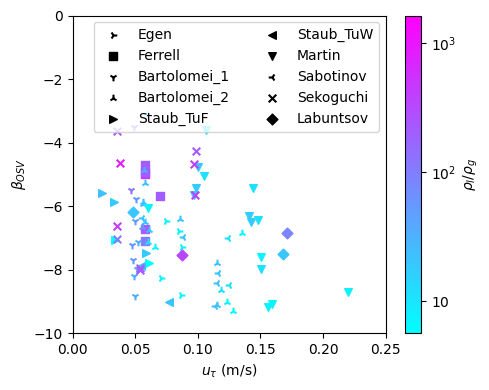

In [115]:
fig = plt.figure(figsize = (5,4))

ax1 = fig.subplots()

legended = [] 

df_ok = df[ (df["Pe"] > 5e4)]
df_ok = df_ok[ df_ok["Geometrie"] != "Annular"]
df_ok = df_ok[ df_ok["Source"] != "Staub_Ch"]

norm_cm = mpl.colors.Normalize(np.log10(min(df["rhotio"])), np.log10(max(df["rhotio"])))
cmap = cm.cool
m = cm.ScalarMappable(norm=norm_cm, cmap=cmap)

for e, row in df_ok.iterrows() :
    plt.scatter(row["utau"], row["beta"], s = 30, marker = dict_marker[row["Source"]], color = m.to_rgba(np.log10(row["rhotio"])))

for e, row in df_ok.iterrows() :
    if not (row["Source"] in legended) : 
        plt.scatter(1.e8, 1.e8, s = 30, marker = dict_marker[row["Source"]], color = "k", label = row["Source"])
        legended += [row["Source"]]


plt.legend(ncol=2)
plt.xlim(0, 0.25)
plt.ylim(-10, 0)
plt.xlabel(r"$u_\tau$ (m/s)")
plt.ylabel(r"$\beta_{OSV}$")

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_cm, cmap=cmap),
             orientation='vertical', label=r'$\rho_l/\rho_g$', ticks=[1,2,3], ax=ax1)
cbar.ax.set_yticklabels([r"$10$", r"$10^2$", r"$10^3$"])  # vertically oriented colorbar

plt.tight_layout()

plt.savefig("figures/beta_of_utau.pdf")

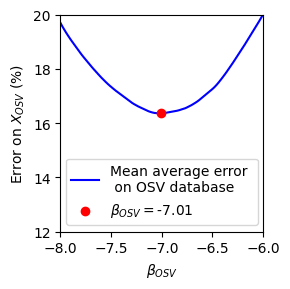

In [116]:
tab_beta_possible = np.linspace(-8, -6, 100)
tab_err2_OSV = np.zeros(100)
tab_err1_OSV = np.zeros(100)

for i in range(100) :
    err_loc = []
    for e, row in df_ok.iterrows() :
        Ts  = CP.PropsSI("T", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])
        rhol= CP.PropsSI("DMASS", "P", row["Pressure"]*1.e5, "T", Ts-row["DT_OSV"], row["Fluide"])
        nul = row["mul"]/rhol
        Cpl = row["Cpl"]
        lambdal = row["lambdal"]
        Hsl = CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])
        Hsv = CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "Q", 1, row["Fluide"])
        Tl_loc = Tl_de_beta(row["Source"], row["Geometrie"], tab_beta_possible[i], Ts, row["Small_length"]*1.e-3, row["Big_length"]*1.e-3, row["q"]*1000, rhol, Cpl, nul, row["utau"])

        X_loc = (CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "T", Tl_loc, row["Fluide"])-Hsl) / (Hsv-Hsl)

        err_loc+= [ (X_loc-row["X_OSV"])/-row["X_OSV"] ]
    tab_err2_OSV[i] = np.average(np.array(err_loc)**2)**.5*100
    tab_err1_OSV[i] = np.average(np.abs(err_loc))*100

plt.figure(figsize = (3,3))
plt.xlim(-8,-6)
plt.ylim(12, 20 )
plt.xlabel(r"$\beta_{OSV}$")
plt.ylabel(r"Error on $X_{OSV}$ (%)")
plt.plot(tab_beta_possible,tab_err1_OSV, "b-", label = "Mean average error \n on OSV database" )
beta_opt = tab_beta_possible[tab_err1_OSV==min(tab_err1_OSV)][0]
plt.scatter(tab_beta_possible[tab_err1_OSV==min(tab_err1_OSV)][0],min(tab_err1_OSV), color = 'r', label = r"$\beta_{OSV}=$" + str(tab_beta_possible[tab_err1_OSV==min(tab_err1_OSV)][0])[:5], zorder=10)
plt.legend(loc = "lower center")
plt.tight_layout()

plt.savefig("figures/MAE_database.pdf")

beta_opt = -7


In [117]:
tab_Xbeta = []

for e, row in df.iterrows() :
    Ts  = CP.PropsSI("T", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])
    rhol= CP.PropsSI("DMASS", "P", row["Pressure"]*1.e5, "T", Ts-row["DT_OSV"], row["Fluide"])
    nul = row["mul"]/rhol
    Cpl = row["Cpl"]
    lambdal = row["lambdal"]
    Hsl = CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])
    Hsv = CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "Q", 1, row["Fluide"])
    Tl_loc = Tl_de_beta(row["Source"], row["Geometrie"], beta_opt, Ts, row["Small_length"]*1.e-3, row["Big_length"]*1.e-3, row["q"]*1000, rhol, Cpl, nul, row["utau"])

    tab_Xbeta += [(CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "T", Tl_loc, row["Fluide"])-Hsl) / (Hsv-Hsl)]

df["Xbeta"] = tab_Xbeta

df_ok = df[ (df["Pe"] > 5e4)]
df_ok = df_ok[ df_ok["Geometrie"] != "Annular"]
df_ok = df_ok[ (df["Source"]=="Martin") | (df["Geometrie"]=="Tube")]



/tmp/ipykernel_1260011/2501916138.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ok = df_ok[ (df["Source"]=="Martin") | (df["Geometrie"]=="Tube")]


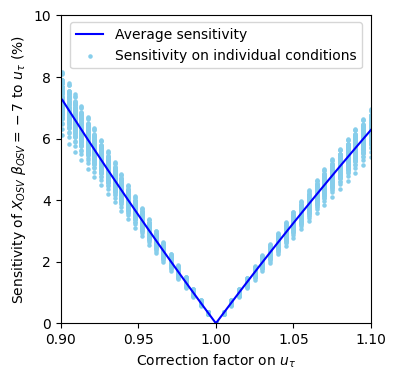

In [118]:
tab_fac_utau = np.array([ 1/(1.+.005*x) for x in range(22, 0, -1) ] + [ 1.+.005*x for x in range(21) ])
tab_err_utau = [ [] for i in range(len(tab_fac_utau))]

plt.figure(figsize = (4,4))

for i in range(len(tab_fac_utau)) :
    fac = tab_fac_utau[i]
    for e, row in df_ok.iterrows() :
        Ts  = CP.PropsSI("T", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])
        rhol= CP.PropsSI("DMASS", "P", row["Pressure"]*1.e5, "T", Ts-row["DT_OSV"], row["Fluide"])
        nul = row["mul"]/rhol
        Cpl = row["Cpl"]
        lambdal = row["lambdal"]
        Hsl = CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "Q", 0, row["Fluide"])
        Hsv = CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "Q", 1, row["Fluide"])
        Tl_loc = Tl_de_beta(row["Source"], row["Geometrie"], beta_opt, Ts, row["Small_length"]*1.e-3, row["Big_length"]*1.e-3, row["q"]*1000, rhol, Cpl, nul, row["utau"]*fac)

        X_loc = (CP.PropsSI("HMASS", "P", row["Pressure"]*1.e5, "T", Tl_loc, row["Fluide"])-Hsl) / (Hsv-Hsl)

        tab_err_utau[i] += [ (X_loc-row["Xbeta"])/-row["Xbeta"] ]
        plt.scatter(tab_fac_utau[i], np.absolute(100* (X_loc-row["Xbeta"])/-row["Xbeta"]), s = 5, color = "skyblue" )

tab_err_utau = np.array(tab_err_utau)

tab_err_utau_final = np.array([ np.average( np.absolute(tab_err_utau[i,:])  ) for i in range(len(tab_fac_utau))])

plt.xlim(.9,1.1)
plt.ylim(0, 10 )
plt.xlabel(r"Correction factor on $u_\tau$")
plt.ylabel(r"Sensitivity of $X_{OSV}$ $\beta_{OSV}=-7$ to $u_\tau$ (%)")
plt.plot(tab_fac_utau,tab_err_utau_final*100, "b-", label = r"Average sensitivity" )
plt.scatter(0,0, s = 5, color = "skyblue", label = r"Sensitivity on individual conditions" )
plt.legend(loc = "upper center")

plt.savefig("figures/Sensitivity_utau.pdf")



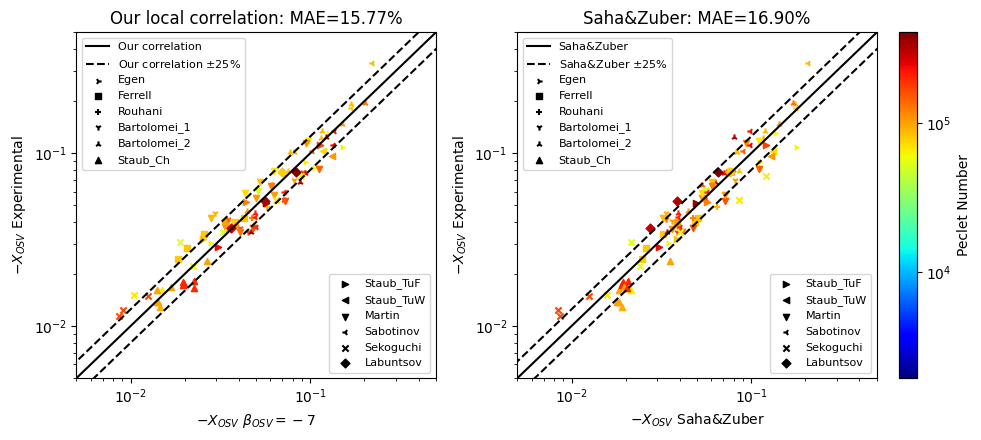

In [119]:
fig = plt.figure(figsize = (10,4.5))

(ax1, ax2) = fig.subplots(1, 2, width_ratios=[4, 5])

norm_cm = mpl.colors.Normalize(np.log10(min(df["Pe"])), np.log10(max(df["Pe"])))
cmap = cm.jet
m = cm.ScalarMappable(norm=norm_cm, cmap=cmap)

df_ok = df[ (df["Pe"] > 5e4)]

tab_p = [ax1.plot([1.e-4, 1.], [1.e-4, 1.], "k-", label = r"Our correlation")[0]]
tab_p+= [ax1.plot([1.e-4, 1.], [1.e-4*1.25, 1.*1.25], "k--", label = r"Our correlation $\pm25\%$")[0]]
ax1.plot([1.e-4, 1.], [1.e-4/1.25, 1./1.25], "k--")

legended = [r"Our correlation", r"Our correlation $\pm25\%$"]

tab_err = []
for e, row in df_ok.iterrows() :
    X_loc = row["Xbeta"]
    ax1.scatter(-X_loc, -row["X_OSV"], s = 20, marker = dict_marker[row["Source"]], color = m.to_rgba(np.log10(row["Pe"])))
    tab_err+= [ (X_loc-row["X_OSV"])/-row["X_OSV"] ]

for e, row in df_ok.iterrows() :
    if not (row["Source"] in legended) :
        tab_p+= [ax1.scatter(1.e8, 1.e8, s = 20, marker = dict_marker[row["Source"]], color ="k", label = row["Source"])]
        legended += [row["Source"]]

ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel(r"$-X_{OSV}$ $\beta_{OSV}=-7$")
ax1.set_ylabel(r"$-X_{OSV}$ Experimental")
ax1.set_ylim(5.e-3, 5.e-1)
ax1.set_xlim(5.e-3, 5.e-1)
ax1b = ax1.twinx()
ax1.legend(tab_p[:8], legended[:8],fontsize = 8, loc = "upper left")
ax1b.legend(tab_p[8:], legended[8:],fontsize = 8, loc = "lower right")
ax1b.axis('off')

ax1.set_title(f"Our local correlation: MAE={str(np.average( (np.array(tab_err)**2)**.5)*100)[:5]}%")

tab_p = [ax2.plot([1.e-4, 1.], [1.e-4, 1.], "k-", label = r"Saha&Zuber")[0]]
tab_p+= [ax2.plot([1.e-4, 1.], [1.e-4*1.25, 1.*1.25], "k--", label = r"Saha&Zuber $\pm25\%$")[0]]
ax2.plot([1.e-4, 1.], [1.e-4/1.25, 1./1.25], "k--")

legended = [r"Saha&Zuber", r"Saha&Zuber $\pm25\%$"]
tab_err = []

for e, row in df_ok.iterrows() :
    X_loc = row["X_SZ"]
    ax2.scatter(-X_loc, -row["X_OSV"], s = 20, marker = dict_marker[row["Source"]], color = m.to_rgba(np.log10(row["Pe"])))
    tab_err+= [ (X_loc-row["X_OSV"])/-row["X_OSV"] ]

for e, row in df_ok.iterrows() :
    if not (row["Source"] in legended) :
        tab_p+= [ax2.scatter(1.e8, 1.e8, s = 20, marker = dict_marker[row["Source"]], color ="k", label = row["Source"])]
        legended += [row["Source"]]


ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel(r"$-X_{OSV}$ Saha&Zuber")
ax2.set_ylabel(r"$-X_{OSV}$ Experimental")
ax2.set_ylim(5.e-3, 5.e-1)
ax2.set_xlim(5.e-3, 5.e-1)
ax2b = ax2.twinx()
ax2b.axis('off')
ax2.legend(tab_p[:8], legended[:8],fontsize = 8, loc = "upper left")
ax2b.legend(tab_p[8:], legended[8:],fontsize = 8, loc = "lower right")

ax2.set_title(f"Saha&Zuber: MAE={str(np.average( (np.array(tab_err)**2)**.5)*100)[:5]}%")

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_cm, cmap=cmap),
             orientation='vertical', label='Peclet Number', ticks=[4,5], ax=ax2)
cbar.ax.set_yticklabels([r"$10^4$", r"$10^5$"])  # vertically oriented colorbar
cbarb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_cm, cmap=cmap),
             orientation='vertical', label=' ', ticks=[], ax=ax2b)

plt.tight_layout()
plt.savefig("figures/Our_correlation_vs_SZ.pdf")


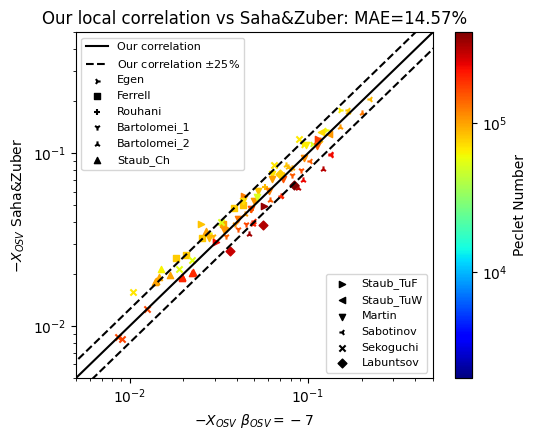

In [120]:
fig = plt.figure(figsize = (5.5,4.5))


df_ok = df[ (df["Pe"] > 5e4)]

(ax1) = fig.subplots()

tab_p = [ax1.plot([1.e-4, 1.], [1.e-4, 1.], "k-", label = r"Our correlation")[0]]
tab_p+= [ax1.plot([1.e-4, 1.], [1.e-4*1.25, 1.*1.25], "k--", label = r"Our correlation $\pm25\%$")[0]]
ax1.plot([1.e-4, 1.], [1.e-4/1.25, 1./1.25], "k--")

legended = [r"Our correlation", r"Our correlation $\pm25\%$"]

tab_err = []
for e, row in df_ok.iterrows() :
    X_loc = row["Xbeta"]
    ax1.scatter(-X_loc, -row["X_SZ"], s = 20, marker = dict_marker[row["Source"]], color = m.to_rgba(np.log10(row["Pe"])))
    tab_err+= [ (X_loc-row["X_SZ"])/-row["X_SZ"] ]

for e, row in df_ok.iterrows() :
    if not (row["Source"] in legended) :
        tab_p+= [ax1.scatter(1.e8, 1.e8, s = 20, marker = dict_marker[row["Source"]], color ="k", label = row["Source"])]
        legended += [row["Source"]]

ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel(r"$-X_{OSV}$ $\beta_{OSV}=-7$")
ax1.set_ylabel(r"$-X_{OSV}$ Saha&Zuber")
ax1.set_ylim(5.e-3, 5.e-1)
ax1.set_xlim(5.e-3, 5.e-1)
ax1b = ax1.twinx()
ax1.legend(tab_p[:8], legended[:8],fontsize = 8, loc = "upper left")
ax1b.legend(tab_p[8:], legended[8:],fontsize = 8, loc = "lower right")
ax1b.axis('off')

ax1.set_title(f"Our local correlation vs Saha&Zuber: MAE={str(np.average( (np.array(tab_err)**2)**.5)*100)[:5]}%")

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_cm, cmap=cmap),
             orientation='vertical', label='Peclet Number', ticks=[4,5], ax=ax1)
cbar.ax.set_yticklabels([r"$10^4$", r"$10^5$"])  # vertically oriented colorbar
cbarb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_cm, cmap=cmap),
             orientation='vertical', label=' ', ticks=[], ax=ax1b)


plt.tight_layout()
plt.savefig("figures/Our_correlation_vs_vs_SZ.pdf")


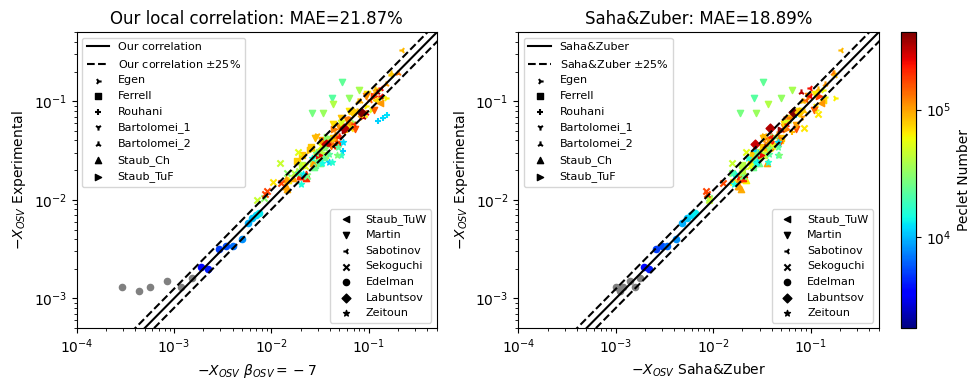

In [121]:
# All data

fig = plt.figure(figsize = (10,4.))


(ax1, ax2) = fig.subplots(1, 2, width_ratios=[4, 5])

tab_p = [ax1.plot([1.e-4, 1.], [1.e-4, 1.], "k-", label = r"Our correlation")[0]]
tab_p+= [ax1.plot([1.e-4, 1.], [1.e-4*1.25, 1.*1.25], "k--", label = r"Our correlation $\pm25\%$")[0]]
ax1.plot([1.e-4, 1.], [1.e-4/1.25, 1./1.25], "k--")

legended = [r"Our correlation", r"Our correlation $\pm25\%$"]

tab_err = []
for e, row in df.iterrows() :
    X_loc = row["Xbeta"]

    colorloc = m.to_rgba(np.log10(row["Pe"]))
    if row["Re"] < 2000 : 
        colorloc = "grey"

    ax1.scatter(-X_loc, -row["X_OSV"], s = 20, marker = dict_marker[row["Source"]], color = colorloc )

    if row["Re"] > 2000 : 
        tab_err+= [ (X_loc-row["X_OSV"])/-row["X_OSV"] ]

for e, row in df.iterrows() :
    if not (row["Source"] in legended) :
        tab_p+= [ax1.scatter(1.e8, 1.e8, s = 20, marker = dict_marker[row["Source"]], color = "k", label = row["Source"])]
        legended += [row["Source"]]

ax1.set_yscale("log")
ax1.set_xscale("log")
ax1.set_xlabel(r"$-X_{OSV}$ $\beta_{OSV}=-7$")
ax1.set_ylabel(r"$-X_{OSV}$ Experimental")
ax1.set_ylim(5.e-4, 5.e-1)
ax1.set_xlim(1.e-4, 5.e-1)
ax1b = ax1.twinx()
ax1.legend(tab_p[:9], legended[:9],fontsize = 8, loc = "upper left")
ax1b.legend(tab_p[9:], legended[9:],fontsize = 8, loc = "lower right")
ax1b.axis('off')

ax1.set_title(f"Our local correlation: MAE={str(np.average( (np.array(tab_err)**2)**.5)*100)[:5]}%")

tab_p = [ax2.plot([1.e-4, 1.], [1.e-4, 1.], "k-", label = r"Saha&Zuber")[0]]
tab_p+= [ax2.plot([1.e-4, 1.], [1.e-4*1.25, 1.*1.25], "k--", label = r"Saha&Zuber $\pm25\%$")[0]]
ax2.plot([1.e-4, 1.], [1.e-4/1.25, 1./1.25], "k--")

legended = [r"Saha&Zuber", r"Saha&Zuber $\pm25\%$"]
tab_err = []

for e, row in df.iterrows() :
    X_loc = row["X_SZ"]

    colorloc = m.to_rgba(np.log10(row["Pe"]))
    if row["Re"] < 2000 : colorloc = "grey"

    ax2.scatter(-X_loc, -row["X_OSV"], s = 20, marker = dict_marker[row["Source"]], color = colorloc )
    if row["Re"] > 2000 : 
        tab_err+= [ (X_loc-row["X_OSV"])/-row["X_OSV"] ]


for e, row in df.iterrows() :
    if not (row["Source"] in legended) : 
        tab_p += [ax2.scatter(1.e8, 1.e8, s = 20, marker = dict_marker[row["Source"]], color = "k", label = row["Source"])]
        legended += [row["Source"]]


ax2.set_yscale("log")
ax2.set_xscale("log")
ax2.set_xlabel(r"$-X_{OSV}$ Saha&Zuber")
ax2.set_ylabel(r"$-X_{OSV}$ Experimental")
ax2.set_ylim(5.e-4, 5.e-1)
ax2.set_xlim(1.e-4, 5.e-1)
ax2b = ax2.twinx()
ax2b.axis('off')
ax2.legend(tab_p[:9], legended[:9],fontsize = 8, loc = "upper left")
ax2b.legend(tab_p[9:], legended[9:],fontsize = 8, loc = "lower right")

ax2.set_title(f"Saha&Zuber: MAE={str(np.average( (np.array(tab_err)**2)**.5)*100)[:5]}%")

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_cm, cmap=cmap),
             orientation='vertical', label='Peclet Number', ticks=[4,5], ax=ax2)
cbar.ax.set_yticklabels([r"$10^4$", r"$10^5$"])  # vertically oriented colorbar
cbarb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_cm, cmap=cmap),
             orientation='vertical', label=' ', ticks=[], ax=ax2b)

plt.tight_layout()
plt.savefig("figures/Our_correlation_vs_SZ_all_data.pdf")
